In [6]:
import evaluate
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import torch

from datasets import Dataset
from sklearn.metrics import (
    confusion_matrix, 
    ConfusionMatrixDisplay, 
    accuracy_score,
    f1_score
)
from transformers import (
    AutoTokenizer,
    DataCollatorWithPadding,
    AutoModelForSequenceClassification,
    Trainer,
    TrainerCallback
)
from transformers.training_args import TrainingArguments

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")


Using cuda


## Read data

In [2]:
data_dir = "../data"
train_data_path = os.path.join(data_dir, 'train_captions_blip.json')
test_data_path = os.path.join(data_dir, 'test_captions_blip.json')
models_dir = "../models"

def generate_df_from_json(json_path):
  with open(json_path) as f:
    data: dict = json.load(f)
    data_formated= {'caption': [], 'label': []}
    for value in data.values():
      data_formated['caption'].append(value['caption'])
      data_formated['label'].append(value['label'])
  
  df = pd.DataFrame.from_dict(data_formated)
  return df

id2label = {
  0: 'Cultural_Religious',
  1: 'Fauna_Flora',
  2: 'Gastronomy',
  3: 'Nature',
  4: 'Sports',
  5: 'Urban_Rural'
}

label2id = {
  'Cultural_Religious': 0,
  'Fauna_Flora': 1,
  'Gastronomy': 2,
  'Nature': 3,
  'Sports': 4,
  'Urban_Rural': 5
}

train_df = generate_df_from_json(train_data_path)
test_df = generate_df_from_json(test_data_path)

train_data = Dataset.from_pandas(train_df).train_test_split(test_size=0.15, seed=4999)
test_data = Dataset.from_pandas(test_df)
print(train_data)

DatasetDict({
    train: Dataset({
        features: ['caption', 'label'],
        num_rows: 571
    })
    test: Dataset({
        features: ['caption', 'label'],
        num_rows: 101
    })
})


([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'Cultural_Religious'),
  Text(1, 0, 'Fauna_Flora'),
  Text(2, 0, 'Gastronomy'),
  Text(3, 0, 'Nature'),
  Text(4, 0, 'Sports'),
  Text(5, 0, 'Urban_Rural')])

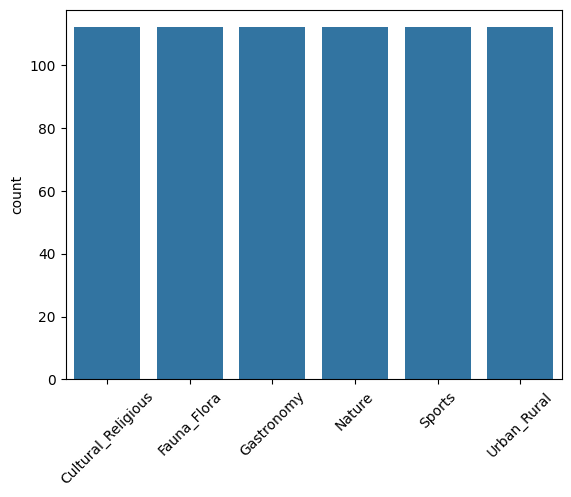

In [21]:
label_count = train_df.groupby(by='label').count()
label_count.columns = ['count']
labels = [id2label[id] for id in label_count.index]
sns.barplot(label_count, x=labels, y='count')
plt.xticks(rotation=45)

## Text classification

In [3]:
#model_id = "google-bert/bert-base-uncased"
#model_id = "distilbert/distilbert-base-uncased"
model_id = "FacebookAI/roberta-base"

### Tokenize data

In [4]:
tokenizer = AutoTokenizer.from_pretrained(model_id)

def preprocess_function(examples):
  return tokenizer(examples["caption"], truncation=True)

tokenized_train_data = train_data.map(preprocess_function, batched=True)
tokenized_test_data = test_data.map(preprocess_function, batched=True)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/571 [00:00<?, ? examples/s]

Map:   0%|          | 0/101 [00:00<?, ? examples/s]

Map:   0%|          | 0/288 [00:00<?, ? examples/s]

### Train model

In [5]:
import copy

accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

model = AutoModelForSequenceClassification.from_pretrained(
    model_id, num_labels=6, id2label=id2label, label2id=label2id
)

training_args = TrainingArguments(
    output_dir=f"{models_dir}/distilbert",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False,
)

class AccuracyHistory(TrainerCallback):
    def __init__(self, trainer):
        super().__init__()
        self.eval_acc = []
        self.train_acc = []
        self._trainer = trainer

    def on_epoch_end(self, args, state, control, **kwargs):
        if control.should_evaluate:
            control_copy = copy.deepcopy(control)
            self._trainer.evaluate(eval_dataset=self._trainer.train_dataset, metric_key_prefix="train")
            return control_copy

    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        if metrics is not None:
            if metrics.get('eval_accuracy'):
                self.eval_acc.append(metrics["eval_accuracy"])
            if metrics.get('train_accuracy'):
                self.train_acc.append(metrics['train_accuracy'])
            
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_data["train"],
    eval_dataset=tokenized_train_data["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    #callbacks=[accuracy_history]
)

trainer.add_callback(AccuracyHistory(trainer))

trainer.train()
trainer.save_model(f"{models_dir}/best_distil_bert")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

{'train_loss': 1.015466570854187, 'train_accuracy': 0.8056042031523643, 'train_runtime': 1.8675, 'train_samples_per_second': 305.752, 'train_steps_per_second': 19.277, 'epoch': 1.0}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 1.0224056243896484, 'eval_accuracy': 0.7821782178217822, 'eval_runtime': 0.331, 'eval_samples_per_second': 305.18, 'eval_steps_per_second': 21.151, 'epoch': 1.0}


  0%|          | 0/36 [00:00<?, ?it/s]

{'train_loss': 0.4150591194629669, 'train_accuracy': 0.8739054290718039, 'train_runtime': 1.9375, 'train_samples_per_second': 294.715, 'train_steps_per_second': 18.581, 'epoch': 2.0}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.47956880927085876, 'eval_accuracy': 0.8811881188118812, 'eval_runtime': 0.3427, 'eval_samples_per_second': 294.716, 'eval_steps_per_second': 20.426, 'epoch': 2.0}


  0%|          | 0/36 [00:00<?, ?it/s]

{'train_loss': 0.2969479560852051, 'train_accuracy': 0.9054290718038529, 'train_runtime': 1.9273, 'train_samples_per_second': 296.272, 'train_steps_per_second': 18.679, 'epoch': 3.0}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.456590861082077, 'eval_accuracy': 0.8514851485148515, 'eval_runtime': 0.3465, 'eval_samples_per_second': 291.447, 'eval_steps_per_second': 20.199, 'epoch': 3.0}


  0%|          | 0/36 [00:00<?, ?it/s]

{'train_loss': 0.1954597681760788, 'train_accuracy': 0.9492119089316988, 'train_runtime': 2.11, 'train_samples_per_second': 270.619, 'train_steps_per_second': 17.062, 'epoch': 4.0}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.34446480870246887, 'eval_accuracy': 0.8910891089108911, 'eval_runtime': 0.4144, 'eval_samples_per_second': 243.741, 'eval_steps_per_second': 16.893, 'epoch': 4.0}


  0%|          | 0/36 [00:00<?, ?it/s]

{'train_loss': 0.1744382381439209, 'train_accuracy': 0.9474605954465849, 'train_runtime': 2.1182, 'train_samples_per_second': 269.57, 'train_steps_per_second': 16.996, 'epoch': 5.0}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.32412251830101013, 'eval_accuracy': 0.8910891089108911, 'eval_runtime': 0.4, 'eval_samples_per_second': 252.476, 'eval_steps_per_second': 17.498, 'epoch': 5.0}
{'train_runtime': 72.3382, 'train_samples_per_second': 39.467, 'train_steps_per_second': 2.488, 'train_loss': 0.6759162478976779, 'epoch': 5.0}


In [6]:
accuracy_history = trainer.pop_callback(AccuracyHistory)

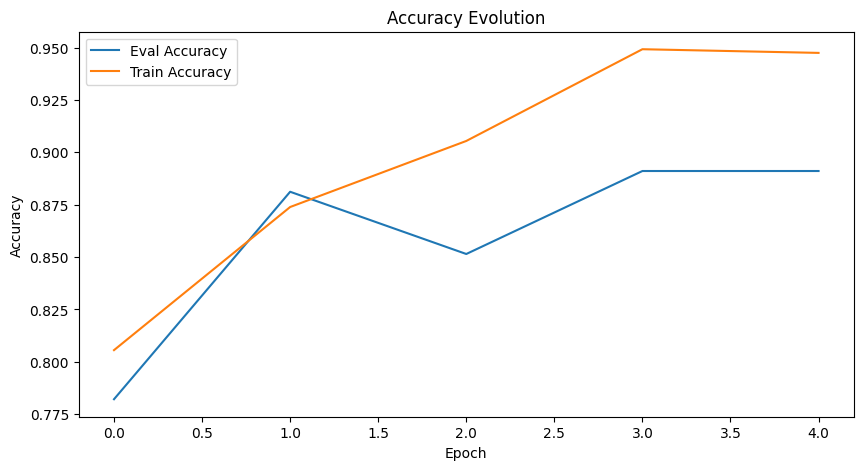

In [7]:
# Plot the train and test accuracy evolution
plt.figure(figsize=(10, 5))
plt.plot(accuracy_history.eval_acc, label='Eval Accuracy')
plt.plot(accuracy_history.train_acc, label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Evolution')
plt.legend()
plt.show()

In [8]:

# After training, evaluate the model on the test set and compute the confusion matrix
predictions, labels, _ = trainer.predict(tokenized_test_data)
predictions = np.argmax(predictions, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(labels, predictions, labels=list(label2id.values()))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label2id.keys()))

  0%|          | 0/18 [00:00<?, ?it/s]

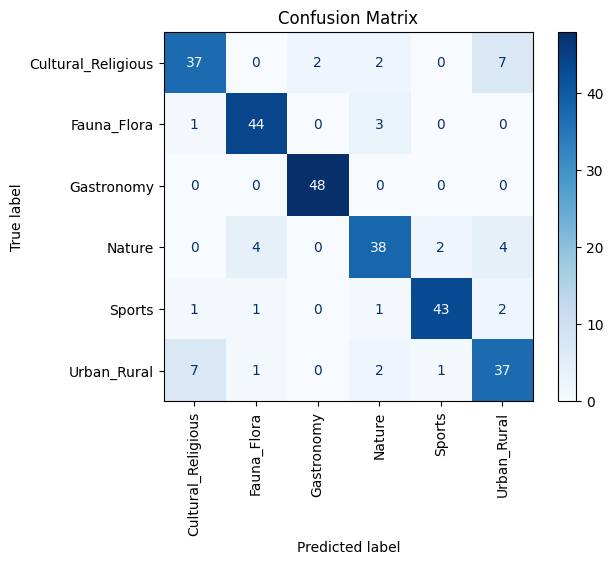

In [9]:

# Plot the confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xticks(rotation=90)
plt.show()

In [10]:
acc = accuracy_score(labels, predictions)
f1 = f1_score(labels, predictions, average='macro')

print(f"F1: {f1}")
print(f"Accuracy: {acc}")

F1: 0.8572152265161384
Accuracy: 0.8576388888888888
